In [15]:
import re
import numpy as np
import pandas as pd
import unicodedata as ud

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [16]:
# ========= 1) LOAD =========
file_path = "NewCopy15cleanCarsCopy1df_filtered.csv"
df = pd.read_csv(file_path, encoding="utf-8-sig")  # BOM-safe

# (Optional) normalize weird whitespace in column names
def _clean_col(s: str) -> str:
    s = ud.normalize("NFKC", str(s))
    s = s.replace("\ufeff", "").replace("\u200b", "").replace("\u200c", "").replace("\u200d", "")
    return " ".join(s.strip().split())
df.columns = [_clean_col(c) for c in df.columns]

print("Columns found:", list(df.columns))

Columns found: ['Company Names', 'Cars Names', 'Engines', 'Capacity', 'HorsePower', 'Total Speed', 'Performance', 'Cars Prices', 'Fuel Types', 'Seats', 'Torque']


In [17]:
# ========= 2) LOAD & NUMERIC TYPE PARSING =========

df = pd.read_csv(file_path, encoding="utf-8-sig", thousands=",")
# enforce numeric (will raise if any stray text slipped through)
df["Cars Prices"] = pd.to_numeric(df["Cars Prices"], errors="raise")
df["Capacity"]    = pd.to_numeric(df["Capacity"], errors="raise")
df["Seats"]       = pd.to_numeric(df["Seats"], errors="raise")

In [18]:
# Drop rows with missing target
df = df.dropna(subset=["Cars Prices"]).reset_index(drop=True)

In [19]:
# ========= 3) FEATURES =========
text_cols = ["Company Names", "Fuel Types"]
num_cols  = ["Capacity", "Seats"]
target    = "Cars Prices"

In [20]:
# Sanity check
missing = set(text_cols + num_cols + [target]) - set(df.columns)
if missing:
    raise KeyError(f"Missing columns: {missing}")

In [21]:
# ========= 4) PIPELINE: TF-IDF (text) + NUMERIC =========
def combine_text(X):
    """Combine the selected text columns into a single string per row."""
    if isinstance(X, pd.DataFrame):
        return (X.astype(str).agg(" ".join, axis=1)).to_numpy()
    return (pd.DataFrame(X).astype(str).agg(" ".join, axis=1)).to_numpy()

text_pipe = Pipeline(steps=[
    ("combine", FunctionTransformer(combine_text, validate=False)),
    # Keep tokens like '1.5T', 'i-VTEC', 'G-Limited'
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 2),
        min_df=3,
        max_features=30000,
        token_pattern=r"(?u)\b[\w\.-]+\b"
    ))
])

In [22]:
num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # plays nicely with sparse TF-IDF
])

In [23]:
pre = ColumnTransformer([
    ("text", text_pipe, text_cols),
    ("num",  num_pipe,  num_cols),
])

In [24]:
# Regularized linear model on log(price)
reg = RidgeCV(alphas=np.logspace(-3, 3, 25))

model = Pipeline([
    ("pre", pre),
    ("reg", reg)
])

In [25]:
# ========= 5) TRAIN/TEST & FIT =========
X = df[text_cols + num_cols]
y = np.log1p(df[target])  # log target for stability

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

model.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('combine',
                                                                   FunctionTransformer(func=<function combine_text at 0x7f97405a8ee0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=30000,
                                                                                   min_df=3,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   token_pattern='(?u)\\b[\\w\\.-]+\\b'))]),
                                                  ['Company Names',
                                                   'Fuel Types']),
                                                 ('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy...
                 RidgeCV(alphas=array([1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02, 1.77827941e+02, 3.16227766e+02, 5.62341325e+02,
       1.00000000e+03])))])

In [26]:
# ========= 6) EVALUATION (back on original price scale) =========
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

r2   = r2_score(np.expm1(y_test), y_pred)
mae  = mean_absolute_error(np.expm1(y_test), y_pred)
rmse = mean_squared_error(np.expm1(y_test), y_pred, squared=False)

print("\n=== Test Performance ===")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")



=== Test Performance ===
R²:   0.7628
MAE:  59,638
RMSE: 345,157


In [27]:
# ========= 7) FEATURE INSPECTION (robust to older sklearn) =========
import numpy as np

ct = model.named_steps["pre"]           # ColumnTransformer
reg = model.named_steps["reg"]          # RidgeCV

# Get text feature names from the inner TF-IDF vectorizer
text_vect = ct.named_transformers_["text"].named_steps["tfidf"]
text_features = text_vect.get_feature_names_out()

# Numeric feature names are the original numeric columns
num_features = np.array(num_cols, dtype=object)

# Final feature name order in ColumnTransformer is [text, then num]
feature_names = np.concatenate([text_features, num_features], axis=0)

coefs = reg.coef_
assert len(coefs) == len(feature_names), (
    f"Length mismatch: {len(coefs)} coefs vs {len(feature_names)} features"
)

coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .assign(abs_coef=lambda d: d["coef"].abs())
      .sort_values("abs_coef", ascending=False)
)

print("\nTop +/− features (log-price coefficients):")
print(coef_df.head(20)[["feature", "coef"]].to_string(index=False))

base_price = float(np.exp(reg.intercept_))
print(f"\nBaseline price (exp(intercept)): ~{base_price:,.0f}")


Top +/− features (log-price coefficients):
       feature      coef
bugatti petrol  1.852799
       bugatti  1.852799
   lamborghini  1.721029
       ferrari  1.692281
  volvo diesel -1.571698
         volvo -1.571698
        martin  1.075026
  aston martin  1.075026
         aston  1.075026
 toyota hybrid -0.996673
 martin petrol -0.961646
 motors petrol -0.893200
           gmc -0.825920
        hybrid  0.807290
hyundai hybrid -0.656794
       porsche  0.634703
          ford -0.573285
       hyundai -0.569157
      Capacity  0.563981
        motors -0.545541

Baseline price (exp(intercept)): ~31,031


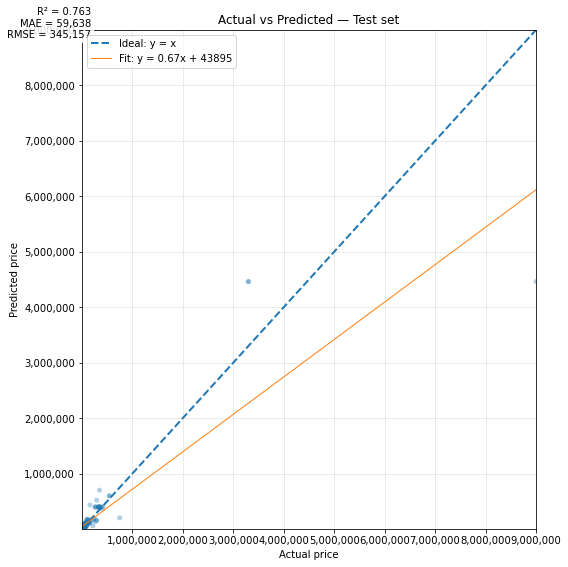

In [ ]:
# ========= 8) PLOT: Actual vs Predicted (Test set) =========
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on test in original price scale
y_true = np.expm1(y_test)
y_pred = np.expm1(model.predict(X_test))

# Metrics for annotation (on original scale)
r2   = r2_score(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

# Plot limits
mn = float(np.nanmin([y_true.min(), y_pred.min()]))
mx = float(np.nanmax([y_true.max(), y_pred.max()]))

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_true, y_pred, alpha=0.35, s=25, edgecolor="none")
ax.plot([mn, mx], [mn, mx], linestyle="--", linewidth=2, label="Ideal: y = x")

# Optional: simple linear fit to highlight bias
m, b = np.polyfit(y_true, y_pred, 1)
ax.plot([mn, mx], [m*mn + b, m*mx + b], linewidth=1, label=f"Fit: y = {m:.2f}x + {b:.0f}")

ax.set_xlim(mn, mx)
ax.set_ylim(mn, mx)
ax.set_xlabel("Actual price")
ax.set_ylabel("Predicted price")
ax.set_title("Actual vs Predicted — Test set")

# Pretty number formatting (e.g., 123,456)
fmt = FuncFormatter(lambda x, _ : f"{x:,.0f}")
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)

ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")

# Metrics box
ax.text(
    0.02, 0.98,
    f"R² = {r2:.3f}\nMAE = {mae:,.0f}\nRMSE = {rmse:,.0f}",
    transform=ax.transAxes, va="top", ha="left",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.85, edgecolor="none")
)

plt.tight_layout()
# To save the figure instead of just showing it, uncomment the next line:
# plt.savefig("actual_vs_predicted_test.png", dpi=200)
plt.show()
